#**Sistem Rekomendasi Pengobatan Osteoarthritis Lutut Menggunakan Model VGG16 dan Decision Tree**


##Hanief Anwar Hayat  
##22/494260/TK/54196  
##Teknik Biomedis  
##Biosibernetika

Sel 1: Instalasi Dependensi

In [ ]:
!pip install tensorflow numpy opencv-python-headless

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from google.colab import files
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Dependensi terinstal dan diimpor.")

Dependensi terinstal dan diimpor.


Sel 2: Unggah dan Ekstrak Dataset

In [ ]:
# Unggah file zip dataset dari laptop dan ekstrak ke direktori sementara
print("Unggah file zip dataset Knee Osteoarthritis dari laptop")
uploaded = files.upload()

# Ekstrak file zip
for file_name in uploaded.keys():
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall('/content/dataset')
        print(f"Dataset diekstrak ke /content/dataset dari {file_name}")
dataset_path = '/content/dataset'

Unggah file zip dataset Knee Osteoarthritis dari laptop


Saving knee osteoarthritis.zip to knee osteoarthritis.zip
Dataset diekstrak ke /content/dataset dari knee osteoarthritis.zip


Sel 3: Pra-pemrosesan Dataset

In [ ]:
# Muat dan proses dataset untuk pelatihan dan validasi
def load_and_preprocess_data(dataset_path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = datagen.flow_from_directory(
        os.path.join(dataset_path, 'training'), # Specify training folder
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        os.path.join(dataset_path, 'validation'), # Specify validation folder
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

train_generator, validation_generator = load_and_preprocess_data(dataset_path)
print("Dataset telah dimuat dan diproses.")

Found 4624 images belonging to 5 classes.
Found 163 images belonging to 5 classes.
Dataset telah dimuat dan diproses.


Sel 4: Bangun Model VGG16

In [ ]:
# Bangun model VGG16 dengan lapisan khusus untuk klasifikasi 5 kelas
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x) # Changed from 3 back to 5 output classes

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_vgg16_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Sel 5: Latih Model VGG16

In [ ]:
# Latih model dengan data pelatihan dan validasi
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Plot akurasi dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 77s 510ms/step - accuracy: 0.3877 - loss: 1.4312 - val_accuracy: 0.3558 - val_loss: 1.4128
Epoch 2/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 69s 473ms/step - accuracy: 0.3926 - loss: 1.3994 - val_accuracy: 0.3865 - val_loss: 1.3736
Epoch 3/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 68s 466ms/step - accuracy: 0.3986 - loss: 1.3756 - val_accuracy: 0.3865 - val_loss: 1.3731
Epoch 4/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.4264 - loss: 1.3273 - val_accuracy: 0.3865 - val_loss: 1.3420
Epoch 5/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 68s 467ms/step - accuracy: 0.4083 - loss: 1.3385 - val_accuracy: 0.3497 - val_loss: 1.4150
Epoch 6/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 68s 471ms/step - accuracy: 0.4187 - loss: 1.3327 - val_accuracy: 0.3865 - val_loss: 1.3295
Epoch 7/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 68s 470ms/step - accuracy: 0.4427 - loss: 1.2819 - val_accuracy: 0.3988 - val_loss: 1.4125
Epoch 8/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 71s 490ms/step - accuracy: 0.4303 - loss: 1

KeyboardInterrupt: 

Sel 6: Evaluasi Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - accuracy: 0.4742 - loss: 1.2329
Validation Loss: 1.2869, Validation Accuracy: 0.4233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


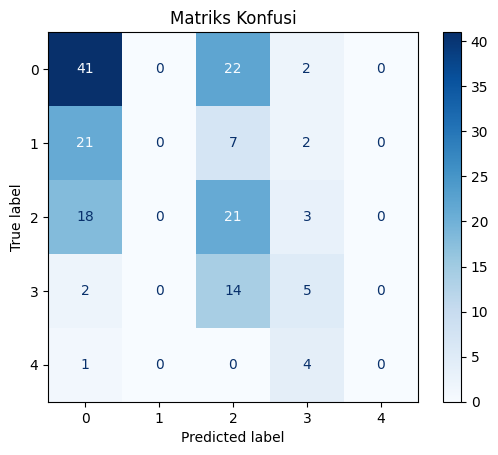

In [ ]:
# Evaluasi model pada set validasi dan buat matriks konfusi
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Prediksi untuk matriks konfusi
y_pred = []
y_true = []
for images, labels in validation_generator:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= validation_generator.samples:
        break

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriks Konfusi')
plt.show()

Sel 7: Implementasi Decision Tree

In [ ]:
# Fungsi untuk rekomendasi pengobatan berdasarkan KL grade, usia, dan BMI
def recommend_treatment(kl_grade, age, bmi):
    if kl_grade == 0:
        return "Tidak perlu pengobatan"
    elif kl_grade == 1:
        treatment = "Manajemen konservatif: olahraga, edukasi"
        if bmi > 25:
            treatment += ", penurunan berat badan"
        return treatment
    elif kl_grade == 2:
        treatment = "Manajemen konservatif: olahraga, edukasi, NSAID"
        if bmi > 25:
            treatment += ", penurunan berat badan"
        return treatment
    elif kl_grade == 3:
        treatment = "Manajemen konservatif: olahraga, edukasi, NSAID, pertimbangkan injeksi intra-artikular, terapi fisik"
        if bmi > 25:
            treatment += ", penurunan berat badan"
        return treatment
    elif kl_grade == 4:
        if age > 50 and bmi < 40:
            return "Pertimbangkan penggantian lutut total, ditambah manajemen konservatif"
        elif age > 50 and bmi >= 40:
            return "Penurunan berat badan disarankan sebelum mempertimbangkan TKR, ditambah manajemen konservatif"
        else:
            return "Diskusikan dengan spesialis, pertimbangkan manajemen konservatif"
    else:
        return "KL grade tidak valid"

print("Fungsi pohon keputusan telah didefinisikan.")

Fungsi pohon keputusan telah didefinisikan.


Sel 8: Prediksi dan Rekomendasi untuk Gambar Baru

In [ ]:
# Unggah gambar baru dan berikan input usia serta BMI
import cv2
print("Unggah gambar X-ray baru untuk prediksi")
uploaded_image = files.upload()

# Proses gambar baru
for image_name in uploaded_image.keys():
    img = cv2.imread(image_name)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Prediksi KL grade
    predicted_kl_grade = np.argmax(model.predict(img))

    # Input usia dan BMI
    age = int(input("Masukkan usia pasien: "))
    bmi = float(input("Masukkan BMI pasien: "))

    # Dapatkan rekomendasi
    recommendation = recommend_treatment(predicted_kl_grade, age, bmi)
    print(f"Prediksi KL Grade: {predicted_kl_grade}")
    print(f"Rekomendasi Pengobatan: {recommendation}")

Unggah gambar X-ray baru untuk prediksi


Saving 9856831L.png to 9856831L.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Masukkan usia pasien: 55
Masukkan BMI pasien: 30
Prediksi KL Grade: 2
Rekomendasi Pengobatan: Manajemen konservatif: olahraga, edukasi, NSAID, penurunan berat badan
